# 18COC102 -  Advanced Artificial Intelligence Systems - Coursework

<hr>
<p style='color:red'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Experiment C2</p>
<hr>


In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,torch,torchvision

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib
CPython 3.6.7
IPython 7.2.0

numpy 1.15.4
torch 0.4.1
torchvision 0.2.1


In [2]:
# import all dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import os
from tensorboardX import SummaryWriter

In [3]:
# some of line are refer source[1]
# network (VGG16) : this network reduce some convolution cores in oder to improve speed
class VGG16(nn.Module):
    
    def __init__(self):
        
        super(VGG16,self).__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128,128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1,padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3,padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512*4*4,1024)
        self.drop1 = nn.Dropout2d()
        self.fc15 = nn.Linear(1024,1024)
        self.drop2 = nn.Dropout2d()
        self.fc16 = nn.Linear(1024,10)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = x.view(-1,512*4*4)
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)

        return x

#end of source [1]
#source [1] https://juejin.im/entry/5bf51d35e51d454049668d57

In [4]:
# parameters
learning_rate=0.001
batch_size=200
epoch=200
workers=2

In [5]:
# set GPU 
device = torch.device("cuda:0")
# set Netwrok
net = VGG16()
net = net.to(device)
# set optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
# set loss function
loss = nn.CrossEntropyLoss()

In [6]:
# dataloader refer source [2]

# load training dataset
trainingset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                           transform=transforms.ToTensor())

trainingloader = torch.utils.data.DataLoader(trainingset, batch_size=batch_size,shuffle=True, 
                                             num_workers=workers)
# load testing dataset
testingset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

testingloader = torch.utils.data.DataLoader(testingset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

#end of source [2]
#source [2] https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

Files already downloaded and verified
Files already downloaded and verified


In [7]:
#ALL THE CODE IN THIS CELL ARE WRITE BY MY SELF#
# Start training : set net to train model
net.train()

# make two arrays for saving matplotlib data
train_loss = []
train_accu = []
accuracy = 0

# get TersorBoard writer object
writer = SummaryWriter(log_dir='Training')

# Training process
timestart = time.time()
for epoch in range(0,epoch):
    
    # initialize loss,total,correct
    loss_value = 0.0
    total = 0
    correct = 0
    accuracy = 0
    
    # do iteration (total number of training images / batch size) times
    for i, (inputs, labels) in enumerate(trainingloader, 0):
        
        # get the input and its label
        inputs = inputs.to(device)
        labels = labels.to(device)

        # make gradients to 0
        optimizer.zero_grad()

        # forward step
        outputs = net(inputs)
        
        # compute the loss
        l = loss(outputs, labels)
        
        # backward step
        l.backward()
        
        # optimize step
        optimizer.step()

        # compute loss
        loss_value += l.item()
        
        # save to array in oder to output loss image at the end
        train_loss.append(l.item())
        
        # write to tensorboard file
        writer.add_scalars('/GroupC/Loss', {'C2': l.item()}, epoch)

        
        # compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
        accuracy = correct / total * 100.0
        
        # save to array in oder to output accuracy image at the end
        train_accu.append(accuracy)
        
        # write to tensorboard file
        writer.add_scalars('/GroupC/Accuracy', {'C2': accuracy}, epoch)
        

    loss_epoch = loss_value / (500000/batch_size)
    # output the result of this epoch 
    print('[epoch %d]  Loss: %.4f  Accuracy: %.3f %%' %(epoch, loss_epoch , accuracy))

    
# Finish Training
result_training_accuracy = accuracy
result_training_time = (time.time()-timestart)
print('Finished Training! Training process cost %3f sec' %result_training_time)

[epoch 0]  Loss: 0.2279  Accuracy: 12.844 %
[epoch 1]  Loss: 0.2202  Accuracy: 18.248 %
[epoch 2]  Loss: 0.2099  Accuracy: 23.918 %
[epoch 3]  Loss: 0.1972  Accuracy: 27.776 %
[epoch 4]  Loss: 0.1843  Accuracy: 30.172 %
[epoch 5]  Loss: 0.1749  Accuracy: 32.246 %
[epoch 6]  Loss: 0.1678  Accuracy: 34.784 %
[epoch 7]  Loss: 0.1613  Accuracy: 37.994 %
[epoch 8]  Loss: 0.1549  Accuracy: 40.916 %
[epoch 9]  Loss: 0.1482  Accuracy: 44.256 %
[epoch 10]  Loss: 0.1412  Accuracy: 46.902 %
[epoch 11]  Loss: 0.1353  Accuracy: 49.224 %
[epoch 12]  Loss: 0.1295  Accuracy: 51.826 %
[epoch 13]  Loss: 0.1244  Accuracy: 53.978 %
[epoch 14]  Loss: 0.1190  Accuracy: 56.118 %
[epoch 15]  Loss: 0.1151  Accuracy: 57.852 %
[epoch 16]  Loss: 0.1103  Accuracy: 59.840 %
[epoch 17]  Loss: 0.1061  Accuracy: 61.268 %
[epoch 18]  Loss: 0.1018  Accuracy: 63.004 %
[epoch 19]  Loss: 0.0983  Accuracy: 64.162 %
[epoch 20]  Loss: 0.0942  Accuracy: 66.042 %
[epoch 21]  Loss: 0.0912  Accuracy: 67.048 %
[epoch 22]  Loss: 0.

[epoch 181]  Loss: 0.0002  Accuracy: 99.986 %
[epoch 182]  Loss: 0.0002  Accuracy: 99.984 %
[epoch 183]  Loss: 0.0002  Accuracy: 99.988 %
[epoch 184]  Loss: 0.0002  Accuracy: 99.996 %
[epoch 185]  Loss: 0.0002  Accuracy: 99.990 %
[epoch 186]  Loss: 0.0002  Accuracy: 99.996 %
[epoch 187]  Loss: 0.0002  Accuracy: 99.992 %
[epoch 188]  Loss: 0.0002  Accuracy: 99.996 %
[epoch 189]  Loss: 0.0002  Accuracy: 99.998 %
[epoch 190]  Loss: 0.0002  Accuracy: 99.990 %
[epoch 191]  Loss: 0.0002  Accuracy: 99.996 %
[epoch 192]  Loss: 0.0002  Accuracy: 99.994 %
[epoch 193]  Loss: 0.0002  Accuracy: 99.996 %
[epoch 194]  Loss: 0.0002  Accuracy: 99.984 %
[epoch 195]  Loss: 0.0002  Accuracy: 99.986 %
[epoch 196]  Loss: 0.0002  Accuracy: 99.990 %
[epoch 197]  Loss: 0.0002  Accuracy: 99.990 %
[epoch 198]  Loss: 0.0002  Accuracy: 99.984 %
[epoch 199]  Loss: 0.0002  Accuracy: 99.992 %
Finished Training! Training process cost 5431.438394 sec


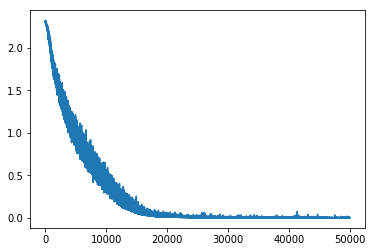

In [8]:
# show the loss
plt.plot(np.arange(len(train_loss)), train_loss)

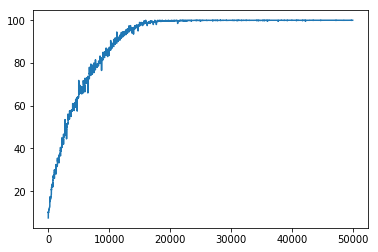

In [9]:
# show the accuracy
plt.plot(np.arange(len(train_accu)), train_accu)

In [10]:
# close the TensorBoard output stream
writer.close()

In [11]:
#ALL THE CODE IN THIS CELL ARE WRITE BY MY SELF#
# Start testing : set net to train model
correct = 0
total = 0

# deactivate the autograd engine
with torch.no_grad():
    
    # do testing iteration
    #for data in testingloader:
        
        # get the input and its label
        #images, labels = data
        #images, labels = images.to(device), labels.to(device)
    for i, (inputs, labels) in enumerate(trainingloader, 0):
        
        # get the input and its label
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward step
        outputs = net(inputs)
        
        # compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()

# Finish Testing
result_testing_accuracy = correct / total * 100.0
print('The accuracy of the network is %.3f %%' % result_testing_accuracy)

The accuracy of the network is 99.994 %


In [12]:
print('[Configuration]')
print('learning rate = %3f' % learning_rate )
print('batch size = %d' % batch_size )
print('epoch = %d' % epoch )
print('')
print('[Expirement Result]')
print('training time = %3f sec' % result_training_time )
print('training accuracy = %.3f %%' %result_training_accuracy )
print('testing accuracy =  %.3f %%' % (100.0 * correct / total))


[Configuration]
learning rate = 0.001000
batch size = 200
epoch = 199

[Expirement Result]
training time = 5431.438394 sec
training accuracy = 99.992 %
testing accuracy =  99.994 %


<b>click <a href='../Main.ipynb'>here</a> to return to Main.ipynb